# Clickbait Detection Project: Final Version

**Course:** NLP Course, Winter 2025  
**Authors:** Jakub Sawicki, Jędrzej Sokołowski, Wiktor Woźniak  
**Supervisor:** Anna Wróblewska

In [24]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.sparse import save_npz
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GridSearchCV
import json
import joblib

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Set seeds for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Loading

In [3]:
from prepare_data import *

cb_2017 = load_webis_corpus_2017()
cb_2022 = load_webis_corpus_2022() # this data contain only clickbait

Successfully loaded data.
Dataset shape: (21997, 2)
Successfully loaded data.
Dataset shape: (4000, 2)


In [4]:
len(cb_2017[cb_2017["label"]==0])/len(cb_2017[cb_2017["label"]==1])

2.9827992033315227

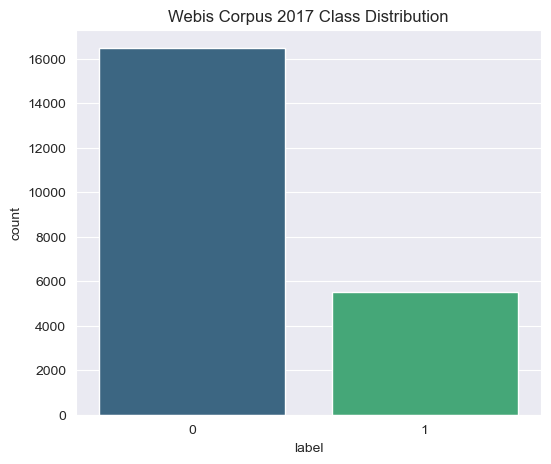

In [5]:
plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=cb_2017, hue='label', palette='viridis', legend=False)
plt.title("Webis Corpus 2017 Class Distribution")
plt.show()

### We can see a great imbalance in the class distribution, to combat that, we extend the dataset with only clickbait data from Webis Clickbait Spoiling Corpus 2022

In [6]:
full_df1, full_df2 = prepare_english_data(test_size=0.5, verbose=0)
full_df = pd.concat([full_df1, full_df2])

print(f"\nFull dataset size: {len(full_df)}")

Successfully loaded data.
Dataset shape: (21997, 2)
Successfully loaded data.
Dataset shape: (4000, 2)
Removed 54 rows with missing or empty headlines.

Full dataset size: 25943


In [7]:
print("Total:", full_df.memory_usage(deep=True).sum() / (1024**2), "MB")

Total: 3.668933868408203 MB


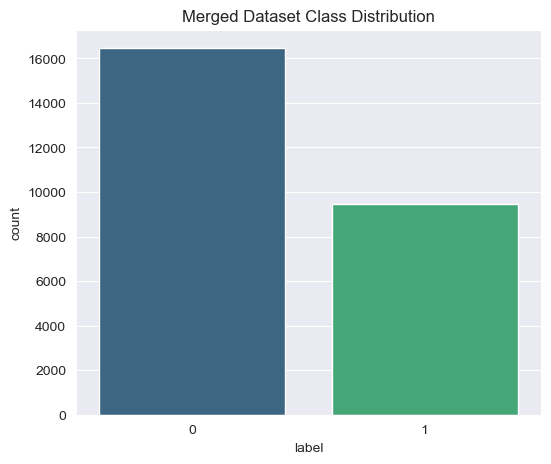

In [8]:
plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=full_df, hue='label', palette='viridis', legend=False)
plt.title("Merged Dataset Class Distribution")
plt.show()

# the merged dataset is still imbalanced - we will apply under sampling to the training set

In [9]:
# models will be trained and fine-tuned using training set with cross-validation / validation loss monitoring
# test set will be used for comparison between models
# 70/15/15 split - training dataset is increased because it will be under sampled

train_df_imbalanced, val_test_df = train_test_split(full_df, test_size=0.3, stratify=full_df['label'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['label'])

# training set under sampling - selecting a random subset of non-clickbait samples to balance the dataset
train_df = undersample_train_df(train_df_imbalanced, random_state=42)

print(f"\nTraining set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

print("Saving raw merged data...")
os.makedirs('data/merged', exist_ok=True)
train_df_imbalanced.to_csv('data/merged/train_imbalanced.csv', index=True)
train_df.to_csv('data/merged/train.csv', index=True)
val_df.to_csv('data/merged/val.csv', index=True)
test_df.to_csv('data/merged/test.csv', index=True)
print("The data has been saved.")


Training set: 13270
Validation set: 3891
Test set: 3892
Saving raw merged data...
The data has been saved.


## 2. Feature Engineering
Extracting linguistic features as defined in the project plan.

In [10]:
# using full_df for EDA

sample_features = perform_feature_engineering_manually(full_df['headline'])
print("Feature Vector Shape:", sample_features.shape)

feature_column_names = [
    'ft_char_count',
    'ft_word_count',
    'ft_exclamation',
    'ft_question',
    'ft_all_caps',
    'ft_polarity',
    'ft_subjectivity',
    'ft_starts_q'
]

sample_features_df = pd.DataFrame(
    sample_features,
    columns=feature_column_names
)

sample_features_df.index = full_df.index
final_df = pd.concat([full_df, sample_features_df], axis=1)

print(f"Final df shape: {final_df.shape}")
final_df.head()

Feature Vector Shape: (25943, 8)
Final df shape: (25943, 10)


,headline,label,ft_char_count,ft_word_count,ft_exclamation,ft_question,ft_all_caps,ft_polarity,ft_subjectivity,ft_starts_q
9145,"""I have no political agenda,"" says #YogenderPa...",0,109.0,17.0,0.0,0.0,0.0,0.0,0.1,0.0
1150,Fox News Channel's host fires back at Stephen ...,1,53.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
12646,NYPD officer resigns to avoid being fired afte...,0,73.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
15000,.@CNNopinion commentators give their verdict o...,0,84.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
16229,Young pretender,1,15.0,2.0,0.0,0.0,0.0,0.1,0.4,0.0


In [11]:
print("Saving data with custom features...")
os.makedirs('data/custom_features', exist_ok=True)
final_df.to_csv('data/custom_features/data.csv', index=True)
print("The data has been saved.")

Saving data with custom features...
The data has been saved.


In [12]:
print("Total:", final_df.memory_usage(deep=True).sum() / (1024**2), "MB")

Total: 5.252368927001953 MB


## 3. Exploratory Data Analysis (EDA) - on the balanced training set
Basic analysis of class distribution and text features.

In [13]:
plt.rcParams["font.size"] = 11

Text(0.5, 0, 'Label (0=Non-Clickbait, 1=Clickbait)')

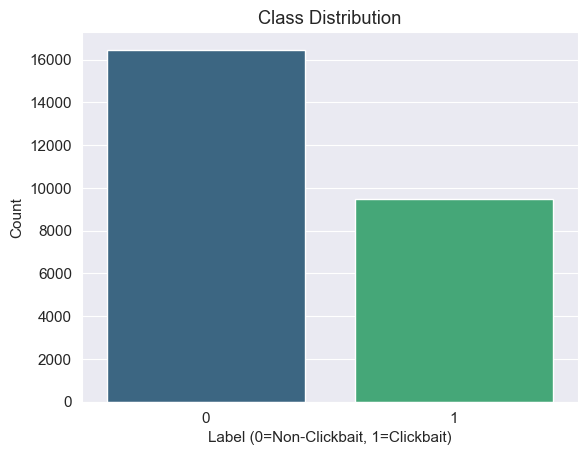

In [14]:
if len(final_df['label'].unique()) > 1:
    sns.countplot(x='label', data=final_df, hue='label', palette='viridis', legend=False)
else:
    final_df['label'].value_counts().plot(kind='bar', color='teal')
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')

In [15]:
len(final_df[final_df["label"]==0])/len(final_df[final_df["label"]==1])

1.7371808398396287

C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\1300938403.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


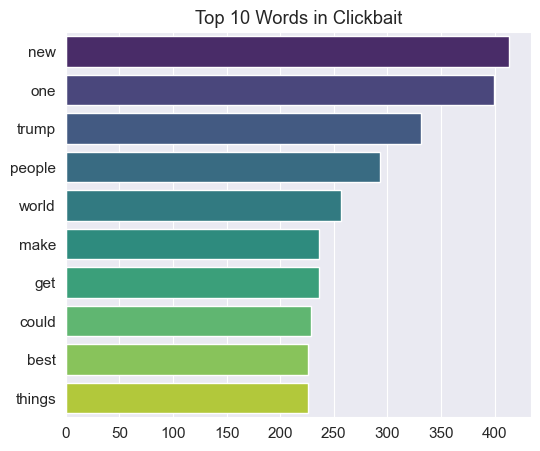

C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\1300938403.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


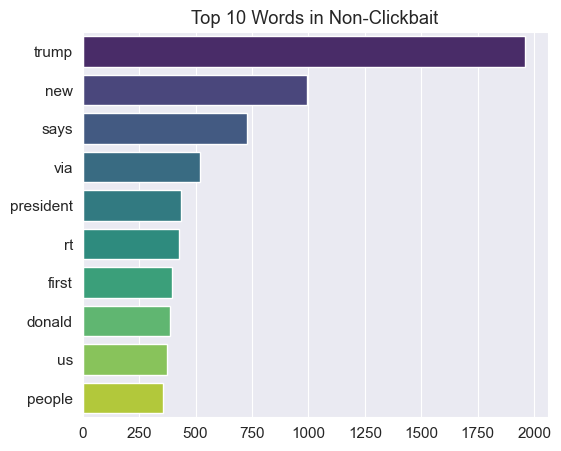

In [16]:
def plot_top_words(df, label, n=10):
    subset = df[df['label'] == label]
    if len(subset) == 0: return

    all_text = " ".join(subset['headline'].astype(str))
    tokens = nltk.word_tokenize(all_text.lower())
    # Remove stopwords and punctuation
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [w for w in tokens if w.isalnum() and w not in stop_words]

    common_words = Counter(tokens).most_common(n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(6, 5))

    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {n} Words in {"Clickbait" if label==1 else "Non-Clickbait"}')
    plt.show()

plot_top_words(final_df, 1)
plot_top_words(final_df, 0)

In [17]:
plt.rcParams["font.size"] = 25

Visualizing All Features (Original + Extracted)


C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\3934004348.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='ft_word_count', data=df, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\3934004348.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\3934004348.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, palette='viridis')


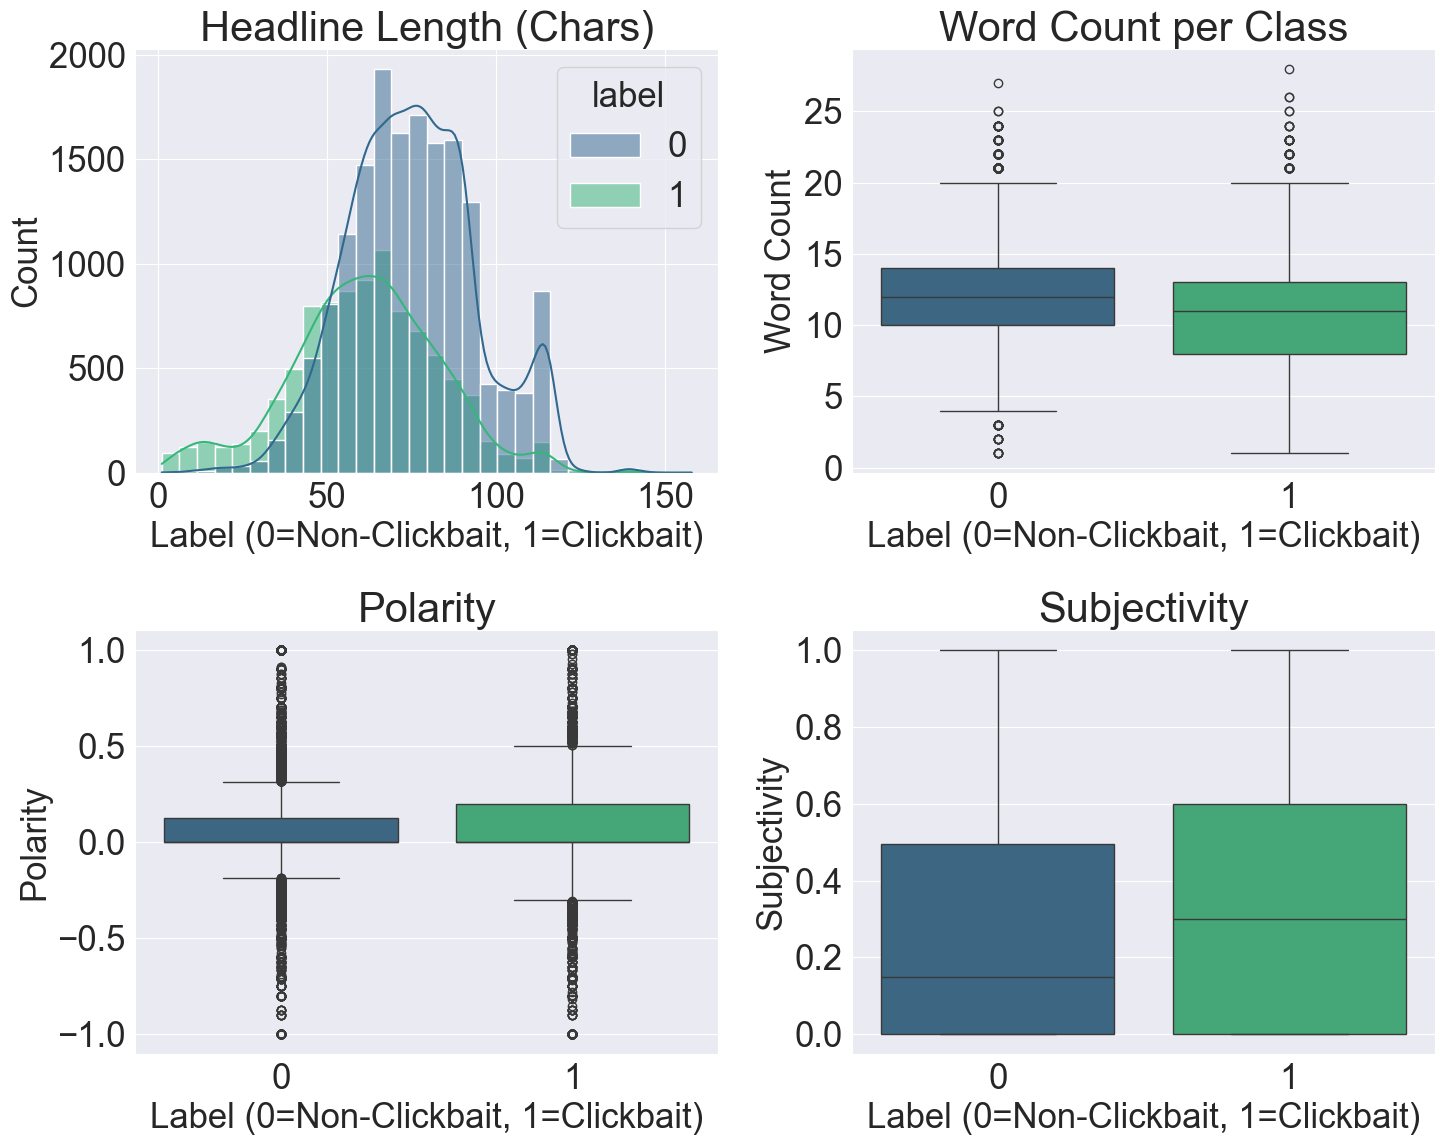

In [18]:
def perform_eda(df):
    extra_features = [
        'ft_polarity',
        'ft_subjectivity',
    ]

    cols = 2
    rows = 2

    plt.figure(figsize=(15, 12))

    # Text Length Histogram
    plt.subplot(rows, cols, 1)
    sns.histplot(data=df, x='ft_char_count', hue='label' if 'label' in df.columns and len(df['label'].unique()) > 1 else None, kde=True, palette='viridis', bins=30)
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')

    plt.title('Headline Length (Chars)')

    # Word Count Boxplot
    plt.subplot(rows, cols, 2)
    sns.boxplot(x='label', y='ft_word_count', data=df, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Word Count')
    plt.title('Word Count per Class')


    for i, feature in enumerate(extra_features):
        plt.subplot(rows, cols, i + 3)
        sns.boxplot(x='label', y=feature, data=df, palette='viridis')
        feature = feature.split("_")[1].capitalize()
        plt.title(feature)
        plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
        plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

print("Visualizing All Features (Original + Extracted)")
perform_eda(final_df)

Visualizing Punctuation and Structural Features


C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\1505007340.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='has_exclamation', data=prop_excl_presence, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\1505007340.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='all_caps_present', data=prop_all_caps, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_3732\1505007340.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='has_question', data=prop_ques_presence, palett

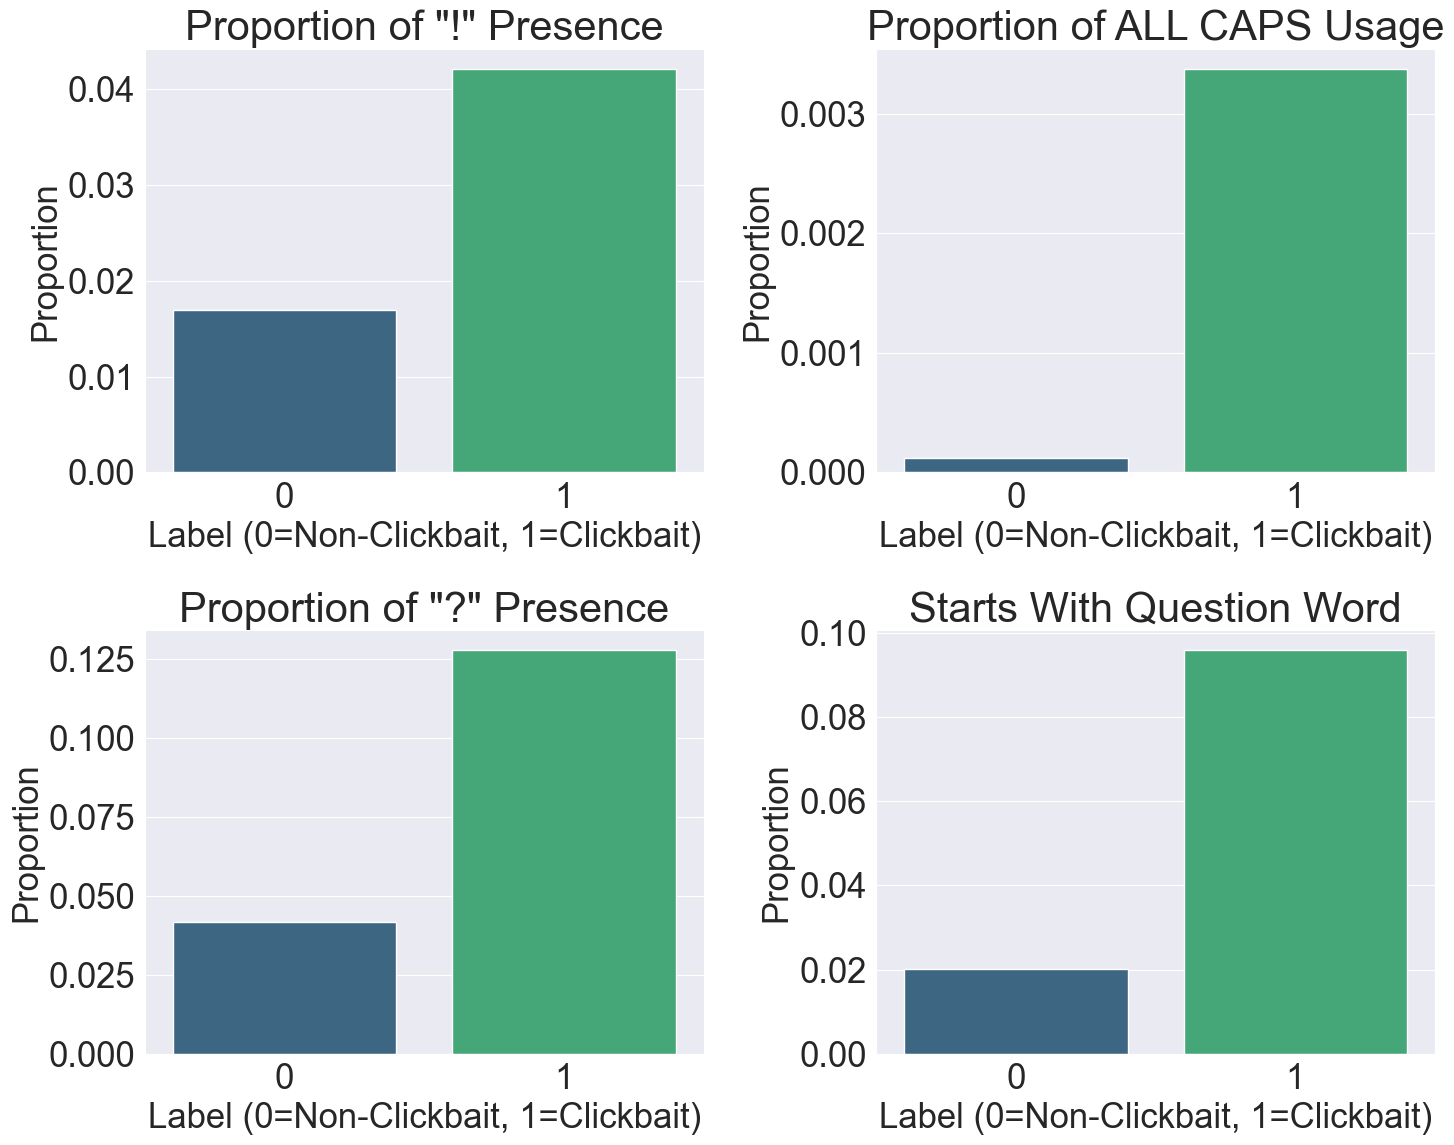

In [19]:
def perform_eda2(df):
    plt.figure(figsize=(15, 12))

    # Exclamation Mark PRESENCE (ft_exclamation >= 1)
    plt.subplot(2, 2, 1)

    # Create binary feature: 1 if >= 1 exclamation mark, 0 otherwise
    df['has_exclamation'] = (df['ft_exclamation'] >= 1).astype(int)

    # Calculate the proportion (mean) of headlines with at least one exclamation mark
    prop_excl_presence = df.groupby('label')['has_exclamation'].mean().reset_index()

    sns.barplot(x='label', y='has_exclamation', data=prop_excl_presence, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Proportion of "!" Presence')
    df.drop(columns=['has_exclamation'], inplace=True, errors='ignore')


    # All Caps Presence (ft_all_caps) - REMAINS THE SAME
    plt.subplot(2, 2, 2)
    df['all_caps_present'] = (df['ft_all_caps'] > 0).astype(int)
    prop_all_caps = df.groupby('label')['all_caps_present'].mean().reset_index()

    sns.barplot(x='label', y='all_caps_present', data=prop_all_caps, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Proportion of ALL CAPS Usage')
    df.drop(columns=['all_caps_present'], inplace=True, errors='ignore')


    # Question Mark PRESENCE (ft_question >= 1)
    plt.subplot(2, 2, 3)

    # Create binary feature: 1 if >= 1 question mark, 0 otherwise
    df['has_question'] = (df['ft_question'] >= 1).astype(int)

    # Calculate the proportion (mean) of headlines with at least one question mark
    prop_ques_presence = df.groupby('label')['has_question'].mean().reset_index()

    sns.barplot(x='label', y='has_question', data=prop_ques_presence, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Proportion of "?" Presence')
    df.drop(columns=['has_question'], inplace=True, errors='ignore')

    # Starts With Question (ft_starts_q)
    plt.subplot(2, 2, 4)
    prop_starts_q = df.groupby('label')['ft_starts_q'].mean().reset_index()

    sns.barplot(x='label', y='ft_starts_q', data=prop_starts_q, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Starts With Question Word')

    plt.tight_layout()
    plt.show()

print("Visualizing Punctuation and Structural Features")
perform_eda2(final_df)

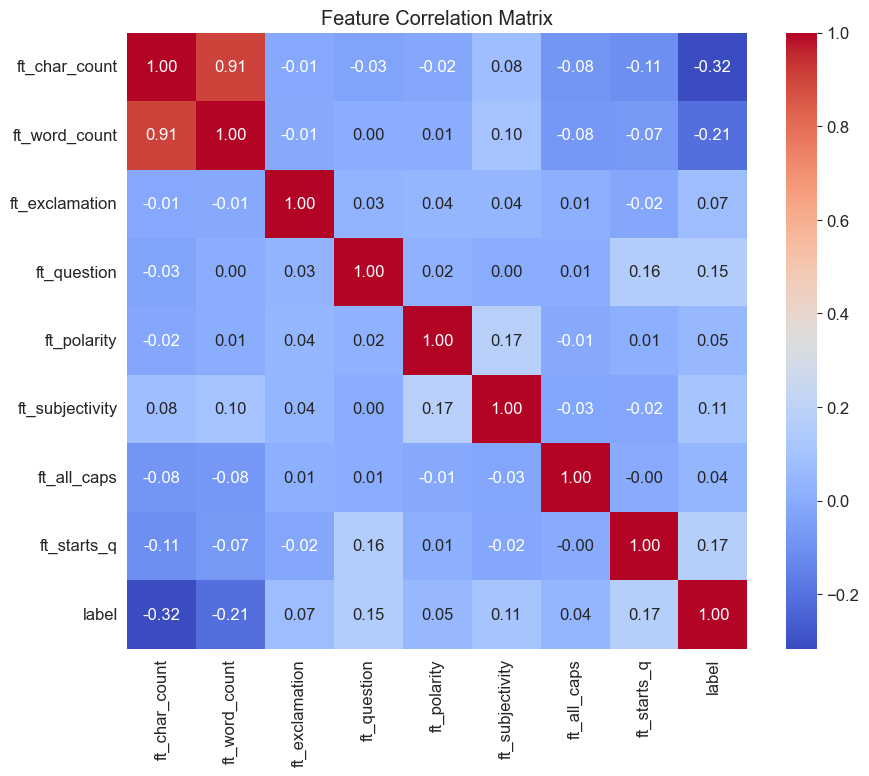

In [20]:
plt.rcParams["font.size"] = 12

# Correlation Matrix
extra_features = [
    'ft_exclamation',
    'ft_question',
    'ft_polarity',
    'ft_subjectivity',
    'ft_all_caps',
    'ft_starts_q'
]

all_numeric = ['ft_char_count', 'ft_word_count'] + extra_features + ['label']
existing_numeric = [c for c in all_numeric if c in final_df.columns]

if len(existing_numeric) > 1:
    plt.figure(figsize=(10, 8))
    corr = final_df[existing_numeric].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.show()

In [21]:
# extracting X, y pairs
if 'train_df' in locals() and 'val_df' in locals() and 'test_df' in locals():
    X_train = train_df['headline']
    y_train = train_df['label']

    X_val = val_df['headline']
    y_val = val_df['label']
    
    X_test = test_df['headline']
    y_test = test_df['label']

## 4. Model A: Classical Machine Learning
Training a Random Forest on Hand-crafted + TF-IDF features.

In [19]:
def build_pipeline_rf(random_state):
    return Pipeline([
        ('features', FeatureUnion([
            ('tfidf', TfidfVectorizer(
                ngram_range=(1, 2),
                max_features=1000
            )),
            ('hand_crafted', HandCraftedFeatures())
        ])),
        ('classifier', RandomForestClassifier(
            random_state=random_state,
            n_jobs=-1
        ))
    ])

In [20]:
def run_experiment_rf(run_id, X_train, y_train, X_test, y_test, results_dir="results/RF", random_state=42):
    print(f"\n===== RUN {run_id} (seed={random_state}) =====")

    pipeline = build_pipeline_rf(random_state)

    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__max_features': ['sqrt', 'log2', None]
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    report = classification_report(
        y_test, y_pred, output_dict=True
    )

    run_dir = f"{results_dir}/run_{run_id}"
    os.makedirs(run_dir, exist_ok=True)

    # Save model
    joblib.dump(grid.best_estimator_, f"{run_dir}/model.joblib")

    # Save metrics
    with open(f"{run_dir}/report.json", "w") as f:
        json.dump(report, f, indent=4)

    with open(f"{run_dir}/best_params.json", "w") as f:
        json.dump(grid.best_params_, f, indent=4)

    return report


In [21]:
NUM_RUNS = 5
base_seed = 42

all_reports = []

for i in range(NUM_RUNS):
    seed = base_seed + i

    report = run_experiment_rf(
        run_id=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        random_state=seed
    )

    all_reports.append(report)


===== RUN 0 (seed=42) =====
Fitting 3 folds for each of 36 candidates, totalling 108 fits

===== RUN 1 (seed=43) =====
Fitting 3 folds for each of 36 candidates, totalling 108 fits

===== RUN 2 (seed=44) =====
Fitting 3 folds for each of 36 candidates, totalling 108 fits

===== RUN 3 (seed=45) =====
Fitting 3 folds for each of 36 candidates, totalling 108 fits

===== RUN 4 (seed=46) =====
Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [22]:
def report_to_dataframe(report, run_id):
    rows = []

    for label, metrics in report.items():
        if label == "accuracy":
            rows.append({
                "run": run_id,
                "label": "accuracy",
                "metric": "accuracy",
                "value": metrics
            })
        else:
            for metric_name, value in metrics.items():
                rows.append({
                    "run": run_id,
                    "label": label,
                    "metric": metric_name,
                    "value": value
                })

    return pd.DataFrame(rows)

all_rows = []

for run_id, report in enumerate(all_reports):
    df_run = report_to_dataframe(report, run_id)
    all_rows.append(df_run)

metrics_df = pd.concat(all_rows, ignore_index=True)

summary_df = (
    metrics_df
    .groupby(["label", "metric"])
    .agg(
        mean=("value", "mean"),
        std=("value", "std")
    )
    .reset_index()
)

# presenting aggregated results
summary_df

,label,metric,mean,std
0,0,f1-score,0.839234,0.005317
1,0,precision,0.858361,0.002819
2,0,recall,0.820972,0.008751
3,0,support,2470.000000,0.000000
4,1,f1-score,0.736846,0.006017
5,1,precision,0.711013,0.009918
6,1,recall,0.764698,0.004913
7,1,support,1422.000000,0.000000
8,accuracy,accuracy,0.800411,0.005772
9,macro avg,f1-score,0.788040,0.005610


In [23]:
# saving the reports

os.makedirs("results/RF", exist_ok=True)

metrics_df.to_csv(
    "results/RF/all_runs_metrics.csv",
    index=False
)

summary_df.to_csv(
    "results/RF/metrics_mean_std.csv",
    index=False
)

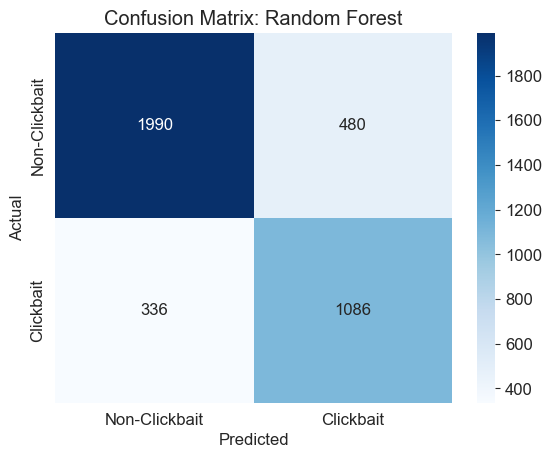

In [22]:
# loading the first run model
model_path = "results/RF/run_0/model.joblib"
model = joblib.load(model_path)

y_pred_test = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait','Clickbait'], yticklabels=['Non-Clickbait','Clickbait'])
plt.title('Confusion Matrix: Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
y_pred_proba = model.predict_proba(X_test)  # shape (n_samples, 2)

os.makedirs("data/RF/", exist_ok=True)
pd.DataFrame({
    "y_true": y_test,
    "prob_non_clickbait": y_pred_proba[:, 0],
    "prob_clickbait": y_pred_proba[:, 1]
}).to_csv("data/RF/test_pred.csv", index=False)

print("Predictions saved")

Predictions saved


In [57]:
mcc_scores = []

for run in range(NUM_RUNS):
    model_path = f"results/RF/run_{run}/model.joblib"
    model = joblib.load(model_path)
    
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    
    print(f"Run {run}: MCC = {mcc:.4f}")

mcc_scores = np.array(mcc_scores)

print("\nAggregated MCC over runs")
print(f"Mean MCC: {mcc_scores.mean():.4f}")
print(f"Std  MCC: {mcc_scores.std(ddof=1):.4f}")  # sample std

Run 0: MCC = 0.5591
Run 1: MCC = 0.5808
Run 2: MCC = 0.5876
Run 3: MCC = 0.5794
Run 4: MCC = 0.5804

Aggregated MCC over runs
Mean MCC: 0.5775
Std  MCC: 0.0108


In [60]:
model_path = "results/RF/run_0/model.joblib"
size_bytes = os.path.getsize(model_path)
size_MB = size_bytes / (1024**2)

print(f"Random Forest model size on disk: {size_MB:.3f} MB")

Random Forest model size on disk: 147.282 MB


In [25]:
# saving the data for classical pipeline

os.makedirs('data/RF', exist_ok=True)

pipeline_classical = build_pipeline_rf(42)
pipeline_classical.fit(train_df["headline"], train_df["label"])

X_train_transformed = pipeline_classical.named_steps['features'].transform(train_df["headline"])
X_val_transformed = pipeline_classical.named_steps['features'].transform(val_df["headline"])
X_test_transformed = pipeline_classical.named_steps['features'].transform(test_df["headline"])

save_npz('data/RF/X_train.npz', X_train_transformed)
save_npz('data/RF/X_val.npz', X_val_transformed)
save_npz('data/RF/X_test.npz', X_test_transformed)

pd.Series(train_df["label"]).to_csv('data/RF/y_train.csv', index=False)
pd.Series(val_df["label"]).to_csv('data/RF/y_val.csv', index=False)
pd.Series(test_df["label"]).to_csv('data/RF/y_val.csv', index=False)

print("Classical pipeline transformed features saved!")

Classical pipeline transformed features saved!


In [46]:
def sparse_memory_MB(sparse_matrix):
    return (sparse_matrix.data.nbytes + sparse_matrix.indices.nbytes + sparse_matrix.indptr.nbytes) / (1024**2)

total_MB = sparse_memory_MB(X_train_transformed) + \
           sparse_memory_MB(X_val_transformed) + \
           sparse_memory_MB(X_test_transformed)

print(f"Total memory of transformed classical pipeline features: {total_MB:.2f} MB")

Total memory of transformed classical pipeline features: 2.66 MB


## 5. Model B: Transformer-based Approach
Fine-tuning DistilBERT.

In [48]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_texts = X_train.astype(str).tolist()
val_texts   = X_val.astype(str).tolist()
test_texts  = X_test.astype(str).tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=64)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=64)

class ClickbaitDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ClickbaitDataset(train_encodings, y_train.tolist())
val_dataset   = ClickbaitDataset(val_encodings, y_val.tolist())
test_dataset  = ClickbaitDataset(test_encodings, y_test.tolist())

In [49]:
def compute_metrics(pred):
        labels = pred.label_ids
        preds  = pred.predictions.argmax(-1)
        return {
            "f1": f1_score(labels, preds, average="weighted"),
            "precision": precision_score(labels, preds, average="weighted"),
            "recall": recall_score(labels, preds, average="weighted")
        }

def distilbert_training(run_id, train_dataset, val_dataset, test_dataset, y_test, base_dir="results/DistilBert", num_epochs=2, batch_size=8, seed=42):
    print(f"\n===== DistilBERT Run {run_id} (seed={seed}) =====")
    
    # Model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    
    # Training arguments
    run_dir = os.path.join(base_dir, f"run_{run_id}")
    os.makedirs(run_dir, exist_ok=True)
    
    training_args = TrainingArguments(
        output_dir=run_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_dir=os.path.join(run_dir, "logs"),
        logging_strategy="steps",
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        save_total_limit=1,
        load_best_model_at_end=True,      # Use validation to pick best checkpoint
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=seed,
        no_cuda=False if torch.cuda.is_available() else True
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,      # validation set used for checkpoints
        compute_metrics=compute_metrics
    )
    
    # Train
    trainer.train()
    
    # Evaluation on test set
    test_pred = trainer.predict(test_dataset)
    y_pred_test = test_pred.predictions.argmax(-1)
    
    # Metrics
    test_report = classification_report(y_test, y_pred_test, output_dict=True)
    
    # Save metrics
    with open(os.path.join(run_dir, "test_metrics.json"), "w") as f:
        json.dump(test_report, f, indent=4)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Non-Clickbait','Clickbait'],
        yticklabels=['Non-Clickbait','Clickbait']
    )
    plt.title(f'Confusion Matrix: DistilBERT Run {run_id}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "confusion_matrix.png"))
    plt.close()
    
    # Save model
    trainer.save_model(os.path.join(run_dir, "model"))
    
    return test_report, y_pred_test

In [28]:
NUM_RUNS = 5
all_reports = []
all_preds   = []

for i in range(NUM_RUNS):
    seed = 42 + i
    report, y_pred = distilbert_training(
        run_id=i,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        y_test=y_test.tolist(),
        seed=seed
    )
    all_reports.append(report)
    all_preds.append(y_pred)


===== DistilBERT Run 0 (seed=42) =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Precision,Recall
100,0.523800,0.456643,0.801457,0.804902,0.799794
200,0.441500,0.438793,0.810091,0.810321,0.812645
300,0.434100,0.472150,0.807310,0.812905,0.805191
400,0.464800,0.430062,0.814393,0.816702,0.813159
500,0.421000,0.533729,0.810930,0.820380,0.808276
600,0.502700,0.445957,0.815272,0.825006,0.812645
700,0.403000,0.493387,0.797377,0.821569,0.793626
800,0.448800,0.412940,0.831305,0.831851,0.830892
900,0.474600,0.446437,0.828454,0.831668,0.827037
1000,0.429200,0.395276,0.836446,0.836622,0.836289



===== DistilBERT Run 1 (seed=43) =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Precision,Recall
100,0.561900,0.841482,0.554032,0.776946,0.577230
200,0.472100,0.480770,0.785711,0.807620,0.781804
300,0.474100,0.496189,0.768196,0.813747,0.764071
400,0.489900,0.461052,0.781735,0.820864,0.777692
500,0.422500,0.406410,0.826940,0.832752,0.824981
600,0.452900,0.416561,0.821012,0.822536,0.820098
700,0.428800,0.467316,0.809295,0.827368,0.805962
800,0.395700,0.470121,0.823001,0.829641,0.820869
900,0.470800,0.496303,0.780944,0.821875,0.776921
1000,0.440300,0.464416,0.809132,0.829496,0.805705



===== DistilBERT Run 2 (seed=44) =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Precision,Recall
100,0.498500,0.454887,0.795611,0.802618,0.793112
200,0.443000,0.673914,0.736546,0.798457,0.732717
300,0.473900,0.419110,0.815410,0.815991,0.814958
400,0.469000,0.480093,0.771859,0.812512,0.767669
500,0.371400,0.435147,0.816143,0.817659,0.815215
600,0.470700,0.429245,0.813578,0.827038,0.810589
700,0.447600,0.438634,0.815362,0.825973,0.812645
800,0.413500,0.398748,0.828951,0.829886,0.828322
900,0.373500,0.572867,0.778376,0.821221,0.774351
1000,0.397000,0.411891,0.826396,0.829546,0.824981



===== DistilBERT Run 3 (seed=45) =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Precision,Recall
100,0.494200,0.548968,0.724382,0.796981,0.721151
200,0.441400,0.444897,0.800367,0.813155,0.797224
300,0.456200,0.439626,0.818339,0.820997,0.817014
400,0.455900,0.451401,0.805357,0.820666,0.802107
500,0.454200,0.464445,0.820806,0.821396,0.820355
600,0.454400,0.467445,0.806954,0.823653,0.803649
700,0.462300,0.424229,0.815809,0.832756,0.812645
800,0.451500,0.395311,0.829599,0.829894,0.829350
900,0.401600,0.481980,0.807168,0.829303,0.803649
1000,0.458100,0.386038,0.829263,0.830315,0.828579



===== DistilBERT Run 4 (seed=46) =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Precision,Recall
100,0.445400,0.582216,0.742614,0.795332,0.738371
200,0.436900,0.463241,0.806046,0.813150,0.803649
300,0.510000,0.442911,0.796392,0.814034,0.792855
400,0.460100,0.453610,0.796332,0.812867,0.792855
500,0.417900,0.453803,0.802853,0.824154,0.799280
600,0.445000,0.423800,0.813752,0.823493,0.811103
700,0.430400,0.397148,0.824185,0.830260,0.822154
800,0.432600,0.576174,0.752692,0.816911,0.749165
900,0.369600,0.415711,0.827840,0.828189,0.827551
1000,0.432100,0.398249,0.826189,0.829529,0.824724


In [29]:
all_rows = [report_to_dataframe(r, i) for i,r in enumerate(all_reports)]
metrics_df = pd.concat(all_rows, ignore_index=True)

summary_df = metrics_df.groupby(["label","metric"]).agg(mean=("value","mean"), std=("value","std")).reset_index()
summary_df.to_csv("results/DistilBert/metrics_mean_std.csv", index=False)

summary_df

,label,metric,mean,std
0,0,f1-score,0.870562,0.010618
1,0,precision,0.881174,0.013737
2,0,recall,0.861053,0.030618
3,0,support,2470.000000,0.000000
4,1,f1-score,0.782244,0.007945
5,1,precision,0.769617,0.031513
6,1,recall,0.797328,0.032423
7,1,support,1422.000000,0.000000
8,accuracy,accuracy,0.837770,0.009724
9,macro avg,f1-score,0.826403,0.008301


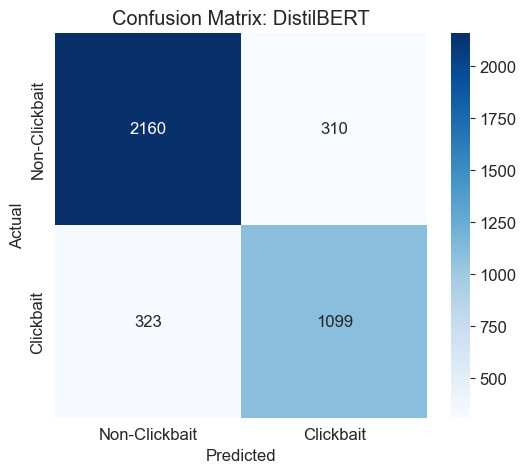

In [29]:
model_dir = "results/DistilBert/run_0/model"
model = DistilBertForSequenceClassification.from_pretrained(model_dir)

trainer = Trainer(model=model)

test_pred = trainer.predict(test_dataset)
y_pred_transformer = test_pred.predictions.argmax(-1)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_transformer)

# Plot using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait','Clickbait'], yticklabels=['Non-Clickbait','Clickbait'])
plt.title('Confusion Matrix: DistilBERT')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
from torch.nn.functional import softmax

test_pred = trainer.predict(test_dataset)
logits = torch.tensor(test_pred.predictions)
y_pred_transformer = logits.argmax(dim=1).numpy()
y_pred_proba = softmax(logits, dim=1).numpy() 

os.makedirs("data/transformer/", exist_ok=True)
pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_transformer,
    "prob_non_clickbait": y_pred_proba[:, 0],
    "prob_clickbait": y_pred_proba[:, 1]
}).to_csv("data/transformer/test_pred.csv", index=False)

In [50]:
mcc_scores = []

for run in range(NUM_RUNS):
    model_dir = f"results/DistilBert/run_{run}/model"
    model = DistilBertForSequenceClassification.from_pretrained(model_dir)
    
    trainer = Trainer(model=model)
    test_pred = trainer.predict(test_dataset)
    
    logits = torch.tensor(test_pred.predictions)
    y_pred = logits.argmax(dim=1).numpy()
    
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    
    print(f"Run {run}: MCC = {mcc:.4f}")

mcc_scores = np.array(mcc_scores)

print("\nAggregated MCC over runs")
print(f"Mean MCC: {mcc_scores.mean():.4f}")
print(f"Std  MCC: {mcc_scores.std(ddof=1):.4f}")

Run 0: MCC = 0.6486


Run 1: MCC = 0.6350


Run 2: MCC = 0.6709


Run 3: MCC = 0.6501


Run 4: MCC = 0.6680

Aggregated MCC over runs
Mean MCC: 0.6545
Std  MCC: 0.0149


In [61]:
# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Approximate memory usage in MB
param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
param_size_MB = param_size_bytes / (1024**2)

print(f"DistilBERT total parameters: {total_params}")
print(f"DistilBERT trainable parameters: {trainable_params}")
print(f"Approximate model size in memory: {param_size_MB:.2f} MB")

DistilBERT total parameters: 66955010
DistilBERT trainable parameters: 66955010
Approximate model size in memory: 255.41 MB


In [30]:
# Data for training Transformer

os.makedirs('data/transformer', exist_ok=True)

# Training dataset
torch.save(train_dataset.encodings['input_ids'], 'data/transformer/train_input_ids.pt')
torch.save(train_dataset.encodings['attention_mask'], 'data/transformer/train_attention_mask.pt')
torch.save(torch.tensor(y_train.tolist()), 'data/transformer/train_labels.pt')

# Validation dataset
torch.save(val_dataset.encodings['input_ids'], 'data/transformer/val_input_ids.pt')
torch.save(val_dataset.encodings['attention_mask'], 'data/transformer/val_attention_mask.pt')
torch.save(torch.tensor(y_val.tolist()), 'data/transformer/val_labels.pt')

# Test dataset
torch.save(test_dataset.encodings['input_ids'], 'data/transformer/test_input_ids.pt')
torch.save(test_dataset.encodings['attention_mask'], 'data/transformer/test_attention_mask.pt')
torch.save(torch.tensor(y_test.tolist()), 'data/transformer/test_labels.pt')

print("Transformer tokenized features saved!")

Transformer tokenized features saved!


In [50]:
def tensor_memory_MB(x):
    if isinstance(x, list):
        x = torch.tensor(x)
    return x.numel() * x.element_size() / (1024**2)

# Train
train_input_ids_MB = tensor_memory_MB(train_dataset.encodings['input_ids'])
train_attention_MB = tensor_memory_MB(train_dataset.encodings['attention_mask'])
train_labels_MB = tensor_memory_MB(y_train.tolist())

# Validation
val_input_ids_MB = tensor_memory_MB(val_dataset.encodings['input_ids'])
val_attention_MB = tensor_memory_MB(val_dataset.encodings['attention_mask'])
val_labels_MB = tensor_memory_MB(y_val.tolist())

# Test
test_input_ids_MB = tensor_memory_MB(test_dataset.encodings['input_ids'])
test_attention_MB = tensor_memory_MB(test_dataset.encodings['attention_mask'])
test_labels_MB = tensor_memory_MB(y_test.tolist())

total_MB = (
    train_input_ids_MB + train_attention_MB + train_labels_MB +
    val_input_ids_MB + val_attention_MB + val_labels_MB +
    test_input_ids_MB + test_attention_MB + test_labels_MB
)

print(f"Total memory of Transformer tokenized features: {total_MB:.2f} MB")


Total memory of Transformer tokenized features: 18.70 MB


## 6. Feedforward Neural Network

In [51]:
import gensim.downloader as api

# pretrained GloVe embedding
word_vectors = api.load("glove-wiki-gigaword-50")
embedding_dim = 50

In [52]:
# handcrafted features

handcrafted_train = HandCraftedFeatures().transform(X_train)
handcrafted_val   = HandCraftedFeatures().transform(X_val)
handcrafted_test  = HandCraftedFeatures().transform(X_test)

In [53]:
def headline_to_avg_embedding(headline, word_vectors, embedding_dim=50):
    words = headline.lower().split()
    vecs = [word_vectors[w] for w in words if w in word_vectors]
    if len(vecs) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vecs, axis=0)

X_train_emb = np.array([headline_to_avg_embedding(h, word_vectors) for h in X_train])
X_val_emb = np.array([headline_to_avg_embedding(h, word_vectors) for h in X_val])
X_test_emb = np.array([headline_to_avg_embedding(h, word_vectors) for h in X_test])

In [54]:
X_train_nn = np.hstack([X_train_emb, handcrafted_train])
X_val_nn   = np.hstack([X_val_emb, handcrafted_val])
X_test_nn  = np.hstack([X_test_emb, handcrafted_test])

In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# dataset definition
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmbeddingDataset(X_train_nn, y_train)
val_dataset = EmbeddingDataset(X_val_nn, y_val)
test_dataset = EmbeddingDataset(X_test_nn, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# network definition
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], num_classes=2, dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [37]:
def train_nn_feedforward(run_id, model, train_dataset, val_dataset, test_dataset,
                         epochs=50, batch_size=32, lr=1e-3, seed=42,
                         base_dir="results/FeedForwardNN"):

    torch.manual_seed(seed)
    np.random.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float("inf")
    run_dir = os.path.join(base_dir, f"run_{run_id}")
    os.makedirs(run_dir, exist_ok=True)
    best_model_path = os.path.join(run_dir, "best_model.pt")

    # Training
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_loss += criterion(model(X_batch), y_batch).item() * len(y_batch)
        val_loss /= len(val_dataset)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # Test evaluation
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    # Metrics
    report = classification_report(all_labels, all_preds, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    # Save metrics and confusion matrix
    with open(os.path.join(run_dir, "test_metrics.json"), "w") as f:
        json.dump(report, f, indent=4)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Clickbait','Clickbait'],
                yticklabels=['Non-Clickbait','Clickbait'])
    plt.title(f'Confusion Matrix: NN Run {run_id}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "confusion_matrix.png"))
    plt.close()

    return report, np.array(all_preds)

In [38]:
NUM_RUNS = 5
all_reports, all_preds = [], []

input_dim = X_train_nn.shape[1] # custom features added

for i in range(NUM_RUNS):
    model = FeedForwardNN(input_dim=input_dim)
    report, preds = train_nn_feedforward(
        run_id=i,
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        epochs=100,
        batch_size=32,
        lr=1e-3,
        seed=42 + i,
        base_dir="results/FeedForwardNN"
    )
    all_reports.append(report)
    all_preds.append(preds)

In [39]:
all_rows = [report_to_dataframe(r, i) for i, r in enumerate(all_reports)]
metrics_df = pd.concat(all_rows, ignore_index=True)

summary_df = metrics_df.groupby(["label", "metric"]).agg(
    mean=("value", "mean"),
    std=("value", "std")
).reset_index()

# Saving aggregated results
summary_path = "results/FeedForwardNN/metrics_mean_std.csv"
summary_df.to_csv(summary_path, index=False)

print(f"Aggregated NN report saved to: {summary_path}")

summary_df

Aggregated NN report saved to: results/FeedForwardNN/metrics_mean_std.csv


,label,metric,mean,std
0,0,f1-score,0.832106,0.004634
1,0,precision,0.826600,0.014752
2,0,recall,0.838381,0.023217
3,0,support,2470.000000,0.000000
4,1,f1-score,0.702114,0.011983
5,1,precision,0.712936,0.017576
6,1,recall,0.693390,0.039334
7,1,support,1422.000000,0.000000
8,accuracy,accuracy,0.785406,0.002616
9,macro avg,f1-score,0.767110,0.004649


In [40]:
# saving data

os.makedirs('data/nn', exist_ok=True)

# Training dataset
torch.save(torch.tensor(X_train_nn, dtype=torch.float32), 'data/nn/train_features.pt')
torch.save(torch.tensor(y_train.tolist(), dtype=torch.long), 'data/nn/train_labels.pt')

# Validation dataset
torch.save(torch.tensor(X_val_nn, dtype=torch.float32), 'data/nn/val_features.pt')
torch.save(torch.tensor(y_val.tolist(), dtype=torch.long), 'data/nn/val_labels.pt')

# Test dataset
torch.save(torch.tensor(X_test_nn, dtype=torch.float32), 'data/nn/test_features.pt')
torch.save(torch.tensor(y_test.tolist(), dtype=torch.long), 'data/nn/test_labels.pt')

print("NN embeddings saved")

NN embeddings saved


In [57]:
def tensor_memory_MB(x):
    if isinstance(x, (list, np.ndarray)):
        x = torch.tensor(x)
    return x.numel() * x.element_size() / (1024**2)

# Train
train_features_MB = tensor_memory_MB(X_train_nn)
train_labels_MB   = tensor_memory_MB(y_train.tolist())

# Validation
val_features_MB = tensor_memory_MB(X_val_nn)
val_labels_MB   = tensor_memory_MB(y_val.tolist())

# Test
test_features_MB = tensor_memory_MB(X_test_nn)
test_labels_MB   = tensor_memory_MB(y_test.tolist())

total_MB = (
    train_features_MB + train_labels_MB +
    val_features_MB + val_labels_MB +
    test_features_MB + test_labels_MB
)

print(f"Total memory of NN embeddings + labels: {total_MB:.2f} MB")


Total memory of NN embeddings + labels: 9.48 MB


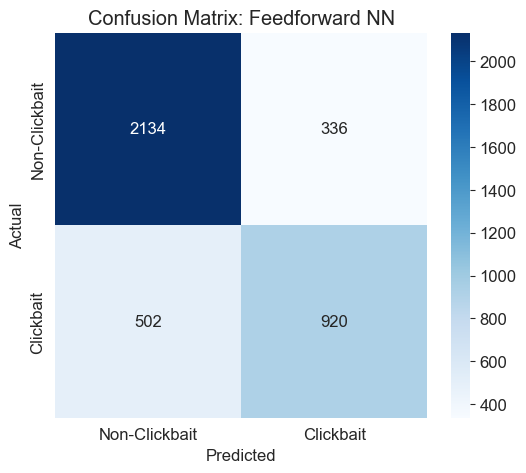

In [40]:
# loading the first model

model = FeedForwardNN(input_dim=input_dim, hidden_dims=[128,64,32], dropout=0.3)
model.load_state_dict(torch.load("results/FeedForwardNN/run_0/best_model.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_preds = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)

# confusion matrix
cm = confusion_matrix(y_test, all_preds)

# Plot using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait','Clickbait'], yticklabels=['Non-Clickbait','Clickbait'])
plt.title('Confusion Matrix: Feedforward NN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [41]:
all_preds = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        probs = softmax(logits, dim=1)
        
        preds = probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.append(probs.cpu())

# Concatenate probabilities
all_probs = torch.cat(all_probs, dim=0).numpy()

os.makedirs("data/nn/", exist_ok=True)
pd.DataFrame({
    "y_true": y_test,
    "y_pred": all_preds,
    "prob_non_clickbait": all_probs[:, 0],
    "prob_clickbait": all_probs[:, 1]
}).to_csv("data/nn/test_pred.csv", index=False)

print("Predictions and probabilities saved to data/nn/test_pred.csv")

Predictions and probabilities saved to data/nn/test_pred.csv


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mcc_scores = []

for run in range(NUM_RUNS):
    model = FeedForwardNN(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],
        dropout=0.3
    )
    model.load_state_dict(torch.load(f"results/FeedForwardNN/run_{run}/best_model.pt"))
    model.to(device)
    model.eval()

    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)

    mcc = matthews_corrcoef(y_test, all_preds)
    mcc_scores.append(mcc)

    print(f"Run {run}: MCC = {mcc:.4f}")

mcc_scores = np.array(mcc_scores)

print("\nAggregated MCC over runs")
print(f"Mean MCC: {mcc_scores.mean():.4f}")
print(f"Std  MCC: {mcc_scores.std(ddof=1):.4f}")

Run 0: MCC = 0.5263
Run 1: MCC = 0.5439
Run 2: MCC = 0.5423
Run 3: MCC = 0.5389
Run 4: MCC = 0.5265

Aggregated MCC over runs
Mean MCC: 0.5356
Std  MCC: 0.0086


In [58]:
num_params = sum(p.numel() for p in model.parameters())
param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
param_size_MB = param_size_bytes / (1024**2)

print(f"Number of parameters: {num_params}")
print(f"Approximate model size in memory: {param_size_MB:.3f} MB")

Number of parameters: 17954
Approximate model size in memory: 0.068 MB


# 7. Baitness analysis

In [1]:
from prepare_data import *
from measure import baitness_measure
import numpy as np
X_test = pd.read_csv(r'data\merged\test.csv').to_numpy()

e:\OneDrive\Pulpit\nlp2025\.venv\Lib\site-packages\lexical_diversity\lex_div.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wikto\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wikto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\wikto\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
baitnes = [0] * len(X_test)
for i,x in enumerate(X_test):
    baitnes[i] = baitness_measure(x[1])

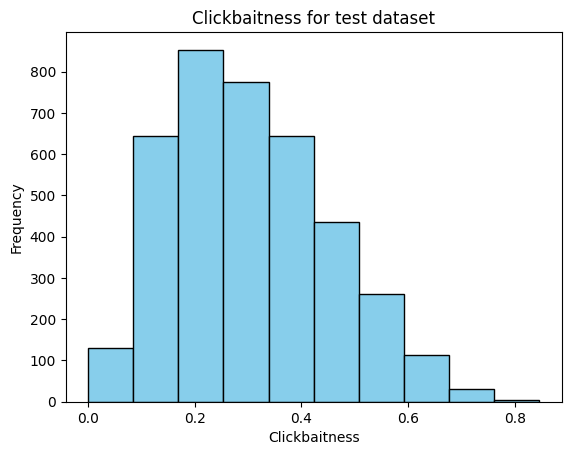

In [3]:
import matplotlib.pyplot as plt

baitnes_np = np.array(baitnes)

plt.hist(baitnes_np, bins=10, color='skyblue', edgecolor='black')
plt.title('Clickbaitness for test dataset')
plt.xlabel('Clickbaitness')
plt.ylabel('Frequency')
plt.show()

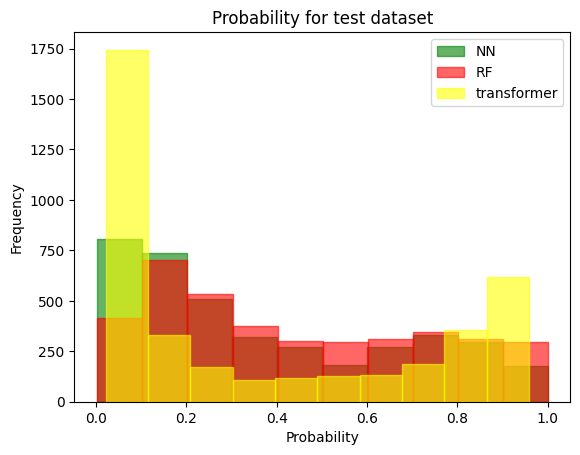

In [17]:
probs_nn = pd.read_csv(r'data\nn\test_pred.csv')['prob_clickbait'].to_numpy()
probs_rf = pd.read_csv(r'data\RF\test_pred.csv')['prob_clickbait'].to_numpy()
probs_transformer = pd.read_csv(r'data\transformer\test_pred.csv')['prob_clickbait'].to_numpy()
plt.hist(probs_nn, bins=10, color='green', edgecolor='green', label = 'NN', alpha = 0.6)
plt.hist(probs_rf, bins=10, color='red', edgecolor='red', label = 'RF', alpha = 0.6)
plt.hist(probs_transformer, bins=10, color='yellow', edgecolor='yellow', label = 'transformer', alpha = 0.6)
plt.title('Probability for test dataset')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

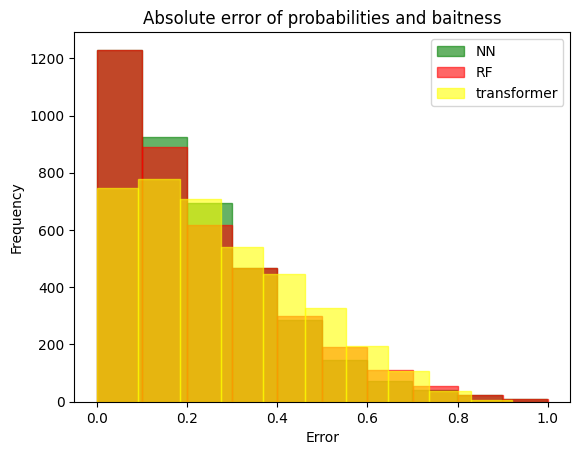

In [25]:
plt.hist(abs(baitnes_np- probs_nn), bins=10, color='green', edgecolor='green', label = 'NN', alpha = 0.6)
plt.hist(abs(baitnes_np - probs_rf), bins=10, color='red', edgecolor='red', label = 'RF', alpha = 0.6)
plt.hist(abs(baitnes_np - probs_transformer), bins=10, color='yellow', edgecolor='yellow', label = 'transformer', alpha = 0.6)
plt.title('Absolute error of probabilities and baitness')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Calculating basic statistics of errors

In [33]:
errors = [
    [abs(baitnes_np - probs_nn), 'NN'],
    [abs(baitnes_np - probs_rf), 'RF'],
    [abs(baitnes_np - probs_transformer), 'transformer']
]

In [37]:
for error, name in errors:
    print(name)
    print('MAE = ', np.mean(error))
    print('Std_MAE = ',np.std(error))
    print('MSE = ', np.mean(error**2))
    print('Std_MSE = ',np.std(error**2))
    print('\n')

NN
MAE =  0.21707211955537073
Std_MAE =  0.17457490291927133
MSE =  0.07759670181753418
Std_MSE =  0.11825386318250349


RF
MAE =  0.22675026937012507
Std_MAE =  0.18838074390431586
MSE =  0.08690298933336772
Std_MSE =  0.1303300626783799


transformer
MAE =  0.26942734731577306
Std_MAE =  0.18430088910756223
MSE =  0.10655791320745216
Std_MSE =  0.12750341648386074


